In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skellam
import matplotlib.pyplot as plt

In [2]:
#Create a Dataframe with 4 season
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index
#coef=pd.DataFrame({'Team':Team})
Data['diff_score']=Data['HG']-Data['AG']


In [3]:
#Create a dataframe with the coefficients to update
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#In order to have identifiability of the covariates 
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)
coef

C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Att,Dif
Team,,
Atalanta,-0.003704,0.011973
Bari,-0.004558,-0.018838
Bologna,-0.001706,-0.019443
Cagliari,0.006387,0.006982
Catania,-0.002721,0.010330
Chievo,-0.001688,-0.008296
Fiorentina,0.016031,0.011502
Genoa,0.014611,-0.005515
Inter,0.000909,0.005924


In [4]:
#Function to calculate the means for the Poisson distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [5]:
def log_prior (coef_att,coef_dif,delta):
    e= norm.logpdf(delta, loc=0, scale=0.1)
    for i in range(len(coef_att)):
        e=+ norm.logpdf(coef_att[i], loc=0, scale=0.1)+ norm.logpdf(coef_dif[i], loc=0, scale=0.01)
    return e

In [6]:
def log_skellam(mu1,mu2,score):
    D=0
    for i in range(len(score)):
        D+=skellam.logpmf(score.iloc[i], mu1.iloc[i], mu2.iloc[i], loc=0)
    return D

In [7]:
#Calculate our unnormalised log posterior
def log_tot (X):
    coef_att=np.concatenate(([-sum(X[1:20])],X[1:20]))
    coef_def=np.concatenate(([-sum(X[20:])],X[20:]))
    H=X[0]
    #Take the log prior
    N=log_prior(coef_att,coef_def,H)
    coef['i1']=coef_att
    coef['i2']=coef_def
    L1,L2=score_coef(coef['i1'],coef['i2'],H,Data)
    Data['j1']=L1
    Data['j2']=L2
    #take the log likelihood 
    N+=log_skellam(Data['j1'],Data['j2'],Data['diff_score'])
    return N 

In [8]:
mu1, mu2=score_coef(coef['Att'],coef['Dif'],delta,Data)
Data['mu1']=mu1
Data['mu2']=mu2


In [9]:
def MCMC(max_iter,theta0,Data): 
    #create vectors to save coef and means at each iteration
    totnameatt= list()
    totnamedef= list()
    theta_t = theta0 
    liste=range(39)
    ret=0;
    coef['Sum_Att']=coef['Att']
    coef['Sum_Dif']=coef['Dif']
    for k in range(max_iter):
       #choose randomly 5 coef to be updated
        a1, a2, a3, a4, a5 =np.random.choice(liste, 5,replace=False)
        v=0.1
        b1=np.random.normal(0,v)
        b2=np.random.normal(0,v)
        b3=np.random.normal(0,v)
        b4=np.random.normal(0,v)
        b5=np.random.normal(0,v)
        
        theta2_t=np.copy(theta_t)
        
        theta2_t[a1]+=b1
        theta2_t[a2]+=b2
        theta2_t[a3]+=b3
        theta2_t[a4]+=b4
        theta2_t[a5]+=b5
        

        coef['New_Att']=np.concatenate(([-sum(theta2_t[1:20])],theta2_t[1:20]))
        coef['New_Dif']=np.concatenate(([-sum(theta2_t[20:])],theta2_t[20:]))
        
        
        mu1 ,mu2=score_coef(coef['New_Att'],coef['New_Dif'],theta2_t[0],Data)
        Data['new_mu1']=mu1
        Data['new_mu2']=mu2
        #Calculate unormalised log posterior

        L1=log_tot(theta_t)

        L2=log_tot(theta2_t)
        
        #Here we have taken the log of the difference of the proposal and transorm back
        alpha= min(1,np.exp(L2-L1))
        u=np.random.uniform(0,1)
        
        if u<alpha:
            name_att = "iter"+str(ret)+"att"
            name_def= "iter"+str(ret)+"def"
            coef[name_att]=coef['New_Att']
            coef[name_def]=coef['New_Dif']
            Data[name_att]=Data['new_mu1']
            Data[name_def]=Data['new_mu2']
            Data['mu1']=Data['new_mu1']
            Data['mu2']=Data['new_mu2']
            theta_t=np.copy(theta2_t)
            ret+=1
            totnameatt.append(name_att)
            totnamedef.append(name_def)
            print(k)
            coef['Sum_Att']+=coef['New_Att']
            coef['Sum_Dif']+=coef['New_Dif']
        
        
    if ret!=0:
        coef['Sum_Att']=coef['Sum_Att']/ret
        coef['Sum_Dif']=coef['Sum_Dif']/ret
    
    return coef, theta_t[0], ret,Data,totnameatt,totnamedef


In [10]:
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))

In [11]:
theta0

array([ 0.00688109, -0.0045578 , -0.00170604,  0.00638717, -0.00272139,
       -0.00168774,  0.01603072,  0.01461059,  0.00090859, -0.00012791,
        0.00089281,  0.00082142, -0.01435043,  0.00036385, -0.00212934,
       -0.00490927, -0.00883367, -0.00396802,  0.01372514,  0.00135925,
       -0.01883756, -0.01944252,  0.00698164,  0.01032999, -0.00829564,
        0.01150246, -0.00551498,  0.00592449,  0.00126005, -0.02427813,
        0.01836739,  0.00061362,  0.00629185,  0.0197894 ,  0.02813077,
        0.0008313 , -0.00904912, -0.01214785, -0.0022977 ])

In [12]:
Coef_club, delta1,it,Data1, name_Att,name_Dif=MCMC(2000,theta0,Data)


5
8
9
14
15
19
20
24
25
29
32
33
36
38
39
49
50
51
53
54
56
57
66
74
76
79
81
86
94
97
100
103
104
105
106
109
112
114
119
121
122
123
126
131
134
136
140
151
157
162
163
164
166
172
178
183
185
187
188
192
198
201
204
206
208
210
215
219
226
227
237
241
251
257
266
272
294
303
304
306
317
320
321
325
327
328
329
346
347
355
358
360
366
367
369
370
372
377
386
389
395
398
401
402
404
405
416
422
426
428
433
438
444
448
457
459
467
470
471
478
492
493
500
501
506
513
514
526
528
529
540
546
550
554
557
566
567
576
583
606
610
618
620
624
625
627
628
629
635
637
648
649
650
657
664
675
678
683
686
687
688
702
712
720
722
724
728
733
739
744
745
747
750
751
764
768
769
774
778
785
788
791
798
804
818
823
834
836
846
855
857
864
871
872
879
881
884
896
914
930
932
933
937
940
959
968
969
975
977
980
984
987
997
1001
1005
1018
1022
1024
1027
1035
1038
1045
1049
1080
1081
1087
1091
1097
1108
1109
1116
1120
1123
1125
1126
1134
1135
1144
1155
1156
1159
1165
1171
1173
1176
1182
1190
1194
1197
1

In [15]:
Coef_club['Home_adv']=delta1
Coef_club.to_csv('Coef_MCMC_Skellam.csv')

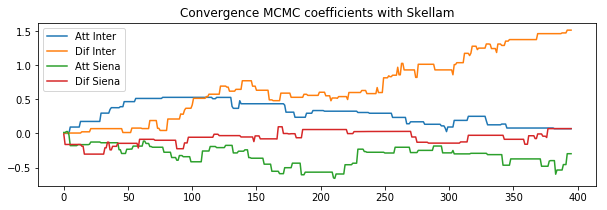

In [13]:
#Plot the evolution of Attacking and difensive Coefficients of Inter and Siena 
def vect(coef):
    
    vect_att_i=[]
    vect_def_i=[]
    vect_att_s=[]
    vect_def_s=[]
    for i in range(it):
        vect1=[]
        vect2=[]
        vect3=[]
        vect4=[]
        col_att = "iter"+str(i)+"att"
        col_def = "iter"+str(i)+"def"
        vect1.append(coef[col_att][8])
        vect2.append(coef[col_def][8])
        vect3.append(coef[col_att][18])
        vect4.append(coef[col_def][18])
        vect_att_i.append(vect1)
        vect_def_i.append(vect2)
        vect_att_s.append(vect3)
        vect_def_s.append(vect4)
    plt.figure(figsize=(10,3))
    plt.plot(vect_att_i, label='Att Inter')
    plt.plot(vect_def_i,label='Dif Inter')
    plt.plot(vect_att_s, label='Att Siena')
    plt.plot(vect_def_s,label='Dif Siena')
    plt.legend(loc='upper left')
    plt.title('Convergence MCMC coefficients with Skellam')
    plt.savefig('MCMC_Skellam.png')
    plt.show()
    return 
vect(Coef_club)

In [14]:
Coef_club

,Att,Dif,Sum_Att,Sum_Dif,New_Att,New_Dif,i1,i2,iter0att,iter0def,...,iter391att,iter391def,iter392att,iter392def,iter393att,iter393def,iter394att,iter394def,iter395att,iter395def
Team,,,,,,,,,,,,,,,,,,,,,
Atalanta,-0.003704,0.011973,0.022639,-0.156036,0.231679,-0.279734,0.231679,-0.279734,-0.099184,-0.056547,...,-0.063999,-0.102061,-0.070925,-0.133854,-0.019332,-0.268399,0.044292,-0.324489,0.284282,-0.284216
Bari,-0.004558,-0.018838,0.188900,-0.196121,0.496714,-0.387005,0.496714,-0.387005,-0.004558,-0.018838,...,0.496714,-0.456717,0.496714,-0.456717,0.496714,-0.456717,0.496714,-0.380777,0.496714,-0.387005
Bologna,-0.001706,-0.019443,-0.075426,-0.217236,-0.194815,-0.333430,-0.194815,-0.333430,-0.001706,-0.019443,...,-0.019009,-0.377103,-0.019009,-0.377103,-0.019009,-0.377103,-0.019009,-0.377103,-0.019009,-0.333430
Cagliari,0.006387,0.006982,-0.151764,0.015559,-0.196558,-0.046906,-0.196558,-0.046906,0.006387,0.006982,...,0.059402,-0.046906,0.059402,-0.046906,0.059402,-0.046906,0.043431,-0.046906,-0.196558,-0.046906
Catania,-0.002721,0.010330,-0.063157,-0.061736,-0.186216,-0.229667,-0.186216,-0.229667,-0.002721,0.010330,...,-0.147087,-0.086685,-0.147087,-0.086685,-0.147087,-0.229667,-0.186216,-0.229667,-0.186216,-0.229667
Chievo,-0.001688,-0.008296,-0.335091,0.093100,-0.413847,0.030749,-0.413847,0.030749,-0.001688,-0.070337,...,-0.413847,0.030749,-0.413847,0.030749,-0.413847,0.030749,-0.413847,0.030749,-0.413847,0.030749
Fiorentina,0.016031,0.011502,0.160275,0.022506,0.049874,0.290006,0.049874,0.290006,0.016031,0.011502,...,0.128582,0.233223,0.049874,0.233223,0.049874,0.309855,0.049874,0.290006,0.049874,0.290006
Genoa,0.014611,-0.005515,0.011635,-0.082672,-0.017951,0.029737,-0.017951,0.029737,0.014611,-0.005515,...,-0.017951,0.029737,-0.017951,0.029737,-0.017951,0.029737,-0.017951,0.029737,-0.017951,0.029737
Inter,0.000909,0.005924,0.292167,0.683262,0.069318,1.513082,0.069318,1.513082,0.000909,0.005924,...,0.069318,1.472252,0.069318,1.513082,0.069318,1.513082,0.069318,1.513082,0.069318,1.513082
